In [23]:
# Install the library needed to read Excel files
!pip install openpyxl

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob
from google.colab import files


Starting combined workload heatmap generation...
Found 2 files to combine:
   - Successfully loaded 'Project-Plan_CRDB.xlsx' (44 tasks)
   - Successfully loaded 'Project-Plan_BTR.xlsx' (8 tasks)

Successfully combined all data. Total tasks: 52
Cleaned and exploded assignee names. Kept 53 assigned tasks.
Found 53 tasks with valid start and due dates.
Generated weekly timeline from 2025-11-16 to 2026-08-02.
Data processing complete. Aggregated into 4-week months.


/tmp/ipython-input-614245285.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, 'Effective_Start'] = df_cleaned['Start date'].fillna(


Added 9 vertical month separators.

Success! Heatmap saved as 'staff_weekly_workload_heatmap.png'
Triggering download for 'staff_weekly_workload_heatmap.png'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

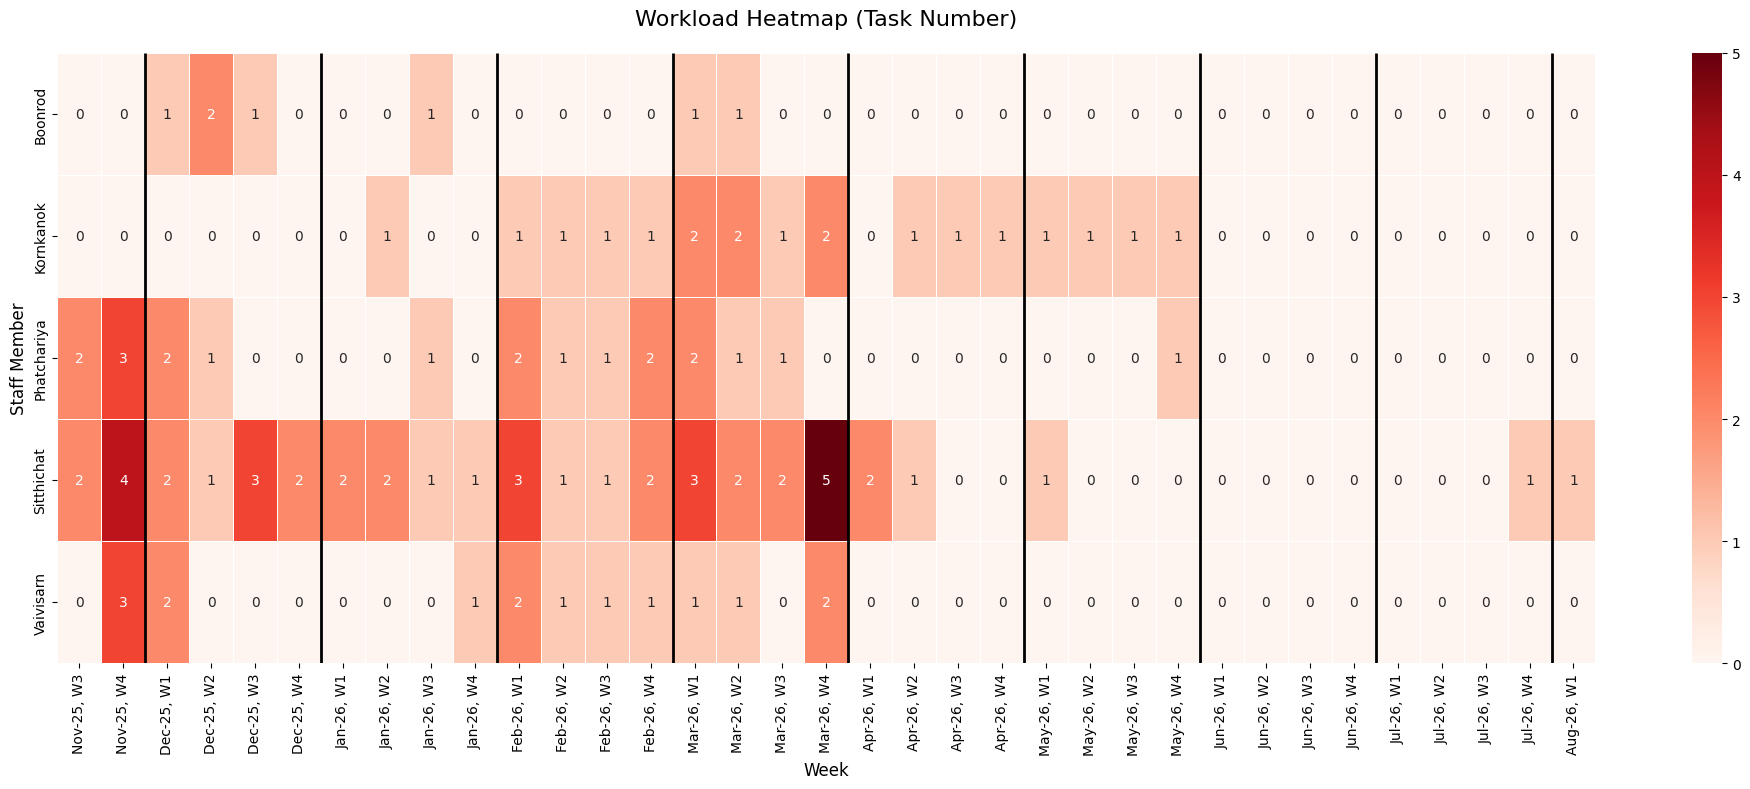

In [25]:

# --- 0. Configuration ---
# NEW: Define a pattern to find all your project files
FILE_PATTERN = 'Project-Plan*.xlsx'
SHEET_NAME = 'Tasks'
OUTPUT_FILE = 'staff_weekly_workload_heatmap.png' # Renamed output

def create_week_label(week_ts):
    """
    Creates a formatted week label (e.g., 'Nov-25, W3')
    from a pandas timestamp. Enforces 4-week-per-month logic.
    """
    if not isinstance(week_ts, pd.Timestamp):
        week_ts = pd.to_datetime(week_ts)

    month_year = week_ts.strftime('%b-%y')
    day = week_ts.day

    if day <= 7:
        week_num = 1
    elif day <= 14:
        week_num = 2
    elif day <= 21:
        week_num = 3
    else: # Days 22-31 are all grouped into W4
        week_num = 4

    return f"{month_year}, W{week_num}"

def main():
    print(f"Starting combined workload heatmap generation...")

    # --- 1. Load Data (from Multiple Excels) ---

    # Find all files in the directory that match the pattern
    file_list = glob.glob(FILE_PATTERN)

    if not file_list:
        print(f"Error: No files found matching pattern '{FILE_PATTERN}'.")
        print("Please make sure you have uploaded all your 'Project Plan_XXX.xlsx' files.")
        sys.exit(1)

    print(f"Found {len(file_list)} files to combine:")

    all_dfs = [] # A list to hold each loaded DataFrame

    for file_path in file_list:
        try:
            # Check if 'Tasks' sheet exists before reading
            xls = pd.ExcelFile(file_path)
            if SHEET_NAME not in xls.sheet_names:
                print(f"   - WARNING: '{SHEET_NAME}' sheet not found in '{file_path}'. Skipping.")
                continue

            temp_df = pd.read_excel(file_path, sheet_name=SHEET_NAME)
            all_dfs.append(temp_df)
            print(f"   - Successfully loaded '{file_path}' ({len(temp_df)} tasks)")
        except Exception as e:
            print(f"   - WARNING: Could not load '{file_path}'. Error: {e}. Skipping.")

    # Check if we actually loaded any data
    if not all_dfs:
        print("Error: No data was successfully loaded. Cannot create heatmap.")
        sys.exit(1)

    # Combine all the individual DataFrames into one big one
    df = pd.concat(all_dfs, ignore_index=True)
    print(f"\nSuccessfully combined all data. Total tasks: {len(df)}")

    # --- The rest of the script is identical ---

    # --- 3. Clean Assignee Names ---
    df['Assigned To'] = df['Assigned To'].fillna('TEMP_UNASSIGNED')
    df['Assigned To'] = df['Assigned To'].str.split(';')

    df_exploded = df.explode('Assigned To')

    df_exploded['Staff Member'] = df_exploded['Assigned To'].str.strip()
    df_exploded['Staff Member'] = df_exploded['Staff Member'].apply(
        lambda x: x.replace('Creagy-', '') if x.startswith('Creagy-') else x
    )

    df_cleaned = df_exploded[
        ~df_exploded['Staff Member'].isin(['TEMP_UNASSIGNED', 'Unassigned'])
    ].copy()

    print(f"Cleaned and exploded assignee names. Kept {len(df_cleaned)} assigned tasks.")

    # --- 4. Define Effective Dates ---

    df_cleaned.loc[:, 'Start date'] = pd.to_datetime(df_cleaned['Start date'])
    df_cleaned.loc[:, 'Due date'] = pd.to_datetime(df_cleaned['Due date'])

    df_cleaned.loc[:, 'Effective_Due'] = df_cleaned['Due date']

    fallback_start = df_cleaned['Effective_Due'] - pd.Timedelta(days=1)
    df_cleaned.loc[:, 'Effective_Start'] = df_cleaned['Start date'].fillna(
        fallback_start
    )

    df_dated = df_cleaned.dropna(subset=['Effective_Start', 'Effective_Due'])

    if df_dated.empty:
        print("Error: No tasks have both an 'Effective_Start' and 'Effective_Due' date.")
        print("Cannot generate heatmap.")
        sys.exit(1)

    print(f"Found {len(df_dated)} tasks with valid start and due dates.")

    # --- 5. Generate Weekly Timeline ---

    min_start = df_dated['Effective_Start'].min()
    max_due = df_dated['Effective_Due'].max()

    all_weeks = pd.date_range(start=min_start, end=max_due, freq='W')

    if all_weeks.empty or all_weeks.max() < max_due:
        new_end_date = all_weeks.max() + pd.Timedelta(weeks=1) if not all_weeks.empty else max_due
        all_weeks = pd.date_range(start=min_start, end=new_end_date, freq='W')

    weeks_df = pd.DataFrame({'Week Checkpoint': all_weeks})
    weeks_df['Week Start'] = weeks_df['Week Checkpoint'] - pd.Timedelta(days=6)

    print(f"Generated weekly timeline from {weeks_df['Week Checkpoint'].min().date()} to {weeks_df['Week Checkpoint'].max().date()}.")

    # --- 6. Calculate Ongoing Tasks ---

    df_dated['key'] = 1
    weeks_df['key'] = 1

    df_cross = pd.merge(df_dated, weeks_df, on='key', how='outer').drop('key', axis=1)

    ongoing_tasks = df_cross[
        (df_cross['Effective_Start'] <= df_cross['Week Checkpoint']) &
        (df_cross['Effective_Due'] >= df_cross['Week Start'])
    ]

    df_agg = ongoing_tasks.groupby(
        ['Staff Member', 'Week Checkpoint']
    ).size().reset_index(name='Task Count')

    # --- 7. Format for Heatmap ---

    df_agg['Week Label'] = df_agg['Week Checkpoint'].apply(create_week_label)

    df_pivot = df_agg.pivot_table(
        index='Staff Member',
        columns='Week Label',
        values='Task Count',
        aggfunc='sum'
    )

    # --- Sort Columns Chronologically ---
    sorted_week_dates = weeks_df['Week Checkpoint'].sort_values().unique()
    ordered_labels_with_dups = [create_week_label(pd.to_datetime(week)) for week in sorted_week_dates]
    ordered_labels_unique = pd.Series(ordered_labels_with_dups).drop_duplicates().tolist()

    df_pivot_sorted = df_pivot.reindex(columns=ordered_labels_unique)

    df_pivot_final = df_pivot_sorted.fillna(0)

    print("Data processing complete. Aggregated into 4-week months.")

    # --- 8. Plot with Seaborn ---

    fig_height = max(8, len(df_pivot_final.index) * 0.6)
    fig_width = max(20, len(df_pivot_final.columns) * 0.5)

    plt.figure(figsize=(fig_width, fig_height))

    ax = sns.heatmap(
        df_pivot_final,
        annot=True,
        fmt=".0f",
        cmap="Reds",
        linewidths=.5
    )

    # --- Add Vertical Month Lines ---
    final_labels = df_pivot_final.columns.tolist()
    month_lines = []
    last_month = ""

    for i, label in enumerate(final_labels):
        month = label.split(',')[0]
        if i > 0 and month != last_month:
            month_lines.append(i)
        last_month = month

    if month_lines:
        ax.vlines(month_lines, *ax.get_ylim(), colors='black', lw=2.0, linestyles='-')
        print(f"Added {len(month_lines)} vertical month separators.")

    plt.title('Workload Heatmap (Task Number)', fontsize=16, pad=20)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Staff Member', fontsize=12)
    plt.tight_layout()

    # Save the figure
    plt.savefig(OUTPUT_FILE, dpi=300)
    print(f"\nSuccess! Heatmap saved as '{OUTPUT_FILE}'")

    # --- 9. Download the File in Colab ---
    print(f"Triggering download for '{OUTPUT_FILE}'...")
    files.download(OUTPUT_FILE)


if __name__ == "__main__":
    main()